# GCN Implementation

In [1]:
#imported all necessary packages that will be used for this assignment
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe
import torch
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torch_geometric.transforms import RandomLinkSplit
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import random

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rodul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rodul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\rodul\anaconda3\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\rodul\anaconda3\Lib\site-packages\torchtex

As a seasoned ICT Business Analyst with 6 years of experience, I've had the privilege of working on various projects. However, my favorite project was the one I worked on in Fraud, which is an area that resonates deeply with me. When I delved into the current state of Fraud Machine Learning (ML) solutions, I found that there is already an abundance of Graph Neural Network (GNN) solutions that primarily rely on graph prediction. These solutions typically involve users as nodes and interactions between them as edges. There are also a few that dealt with edge predictions, specifically edge classification where nodes take the form of customers & financial institutions while transactions took the form of edges; where the goal is to predict whether these transactions (edges) are fraudulent. For these reasons, I was hesitant to explore these existing solutions because they seemed to be rehashing familiar approaches. The lack of novelty in these methods made it difficult for me to get excited about contributing to the same old ideas.I also explored GNN solutions specific to fraudulent calls, but unfortunately, I couldn't find many. This scarcity of solutions led me to investigate datasets specific to fraudulent calls. I found that acquiring these datasets is extremely challenging, which further underscores the lack of solutions catering specifically to fraudulent calls. Given the dearth of solutions in this space, I decided to embark on a project that could potentially make a meaningful contribution in the field of fraudulent call detection.

In the realm of Natural Language Processing (NLP), we've made significant strides in developing solutions that can accurately analyze semantic meaning. With a simple statement, and very easy-to-use inference models such as the pipeline APIs available from huggingface [7]; models can easily be used to accurately predict sentiments, whether it's neutral, happy, angry, or offensive. Imagine if we could have a similar solution in detecting fraudulent calls; that will be very beneficial for fraud detection officers. Research in this space is gaining momentum, and I'm optimistic that soon we will have state-of-the art solutions that can trim down the number of fraud cases worldwide. As someone passionate about this area, I'm eager to contribute in any way I can, starting with my Graph Neural Network (GNN) solution.

In order to tackle the challenge of detecting fraudulent messages, we are proposing a Graph Neural Network (GNN) approach that leverages a graph representing the co-occurrence of words in fraudulent messages. While acquiring a reliable dataset of fraud messages was challenging, I was able to adapt a public dataset of spam and ham messages, which can be used as a proxy for fraudulent messages, as many spam messages are indeed used for fraudulent purposes. The GNN solution consists of nodes representing individual words and edges representing if the words have been used together in the context of fraud messages. The proposed solution will make use of edge-level prediction, specifically link prediction, where the task studies if words are being used together in spam/fraud messages. By predicting the likelihood of words being used together in a spam/fraud message, the proposed GNN solution aims to provide valuable insights for fraud detection officers, enabling them to better understand how fraudulent messages are typically composed. This solution seeks to empower fraud detection officers with a deeper understanding of the linguistic patterns and word combinations commonly used in fraudulent messages, ultimately enhancing their ability to detect and prevent fraudulent activities.

The dataset we will be using in this task is the SMS Spam Collection dataset, sourced from the UCI Machine Learning Repository. It is a comprehensive public dataset comprising a diverse range of SMS messages. The corpus is comprised of three primary sources. Firstly, a collection of 425 SMS spam messages that were manually extracted from the Grumbletext Web site, a UK-based forum where cell phone users share their experiences with SMS spam messages. Secondly, a subset of 3,375 SMS ham messages were randomly selected from the NUS SMS Corpus (NSC), a dataset of approximately 10,000 legitimate messages collected by the Department of Computer Science at the National University of Singapore. The majority of these messages originated from Singaporeans, primarily students attending the university. Thirdly, a list of 450 SMS ham messages was sourced from a PhD Thesis made by Caroline Tag. Finally, the SMS Spam Corpus v.0.1 Big was incorporated, featuring 1,002 ham messages and 322 spam messages. This diverse dataset provides a robust foundation for research and analysis in the field of SMS spam detection [8].

### Preprocessing of  Dataset

In [2]:
#Specified the path of the dataset
file_path = 'spam.csv'

#Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path, encoding='latin1')

#Displayed the first few rows of the DataFrame
print(df.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


Since our primary objective is not to classify texts as spam or ham, but rather to analyze the linguistic patterns in spam messages, we can simplify our approach by focusing solely on the spam data. To streamline our approach, we will remove the ham data and retain only the v1 and v2 columns, as the unnamed columns contain no valuable information. Furthermore, given that we are primarily interested in the texts themselves, specifically the words used together in each row of text, balancing or normalizing the dataset at this point is unnecessary for our task.

In [3]:
#Removed all rows where the value in the 'v1' column is 'ham'
df_filtered = df[df['v1'] != 'ham']

#Displayed the first few rows of the filtered DataFrame
print("\nFiltered DataFrame:")
print(df_filtered.head())


Filtered DataFrame:
      v1                                                 v2 Unnamed: 2  \
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
5   spam  FreeMsg Hey there darling it's been 3 week's n...        NaN   
8   spam  WINNER!! As a valued network customer you have...        NaN   
9   spam  Had your mobile 11 months or more? U R entitle...        NaN   
11  spam  SIX chances to win CASH! From 100 to 20,000 po...        NaN   

   Unnamed: 3 Unnamed: 4  
2         NaN        NaN  
5         NaN        NaN  
8         NaN        NaN  
9         NaN        NaN  
11        NaN        NaN  


In [4]:
#Removed the specified columns
columns_to_remove = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df_filtered = df_filtered.drop(columns=columns_to_remove)

In [5]:
#Displayed the updated DataFrame
print("\nUpdated DataFrame:")
print(df_filtered.head())


Updated DataFrame:
      v1                                                 v2
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
5   spam  FreeMsg Hey there darling it's been 3 week's n...
8   spam  WINNER!! As a valued network customer you have...
9   spam  Had your mobile 11 months or more? U R entitle...
11  spam  SIX chances to win CASH! From 100 to 20,000 po...


Now we will run a series of preprocessing steps so we can have an accurate and meaningful unique set of words. First, let's cleanup by removing empty rows.

In [6]:
#removed records with missing data 
cleaned_df = df_filtered.copy().dropna(subset=['v2'])
cleaned_df = cleaned_df.copy().dropna(subset=['v1'])

#Since we removed records with missing values, we also reset the index of our dataset
cleaned_df.reset_index(drop=True, inplace=True)

Next, we will execute a series of steps designed to filter out words that do not provide significant information for our task. Specifically, we will eliminate common words such as "the", "a", "is", and others that are frequently used in various sentences, regardless of context. These words, often referred to as "stop words", do not contribute meaningfully to our analysis, as they are likely to appear in the majority of messages, regardless of whether they are spam or not. By removing these words, we can simplify our analysis and focus on the more informative words that are more indicative of the message's content and potential spam or fraud status.

In [7]:
#defined preprocess function 
def preprocess(text):#defined the steps to be performed in preprocessing
    res1 = step1(text)
    res2 = step2(res1)
    processed_text = res2
    return processed_text

def step1(text):#split the text into words as tokens
    from nltk.tokenize import word_tokenize #imported nltk word_tokenize
    res1 = word_tokenize(text)#tokenized text
    return res1

def step2(res1):#filtered out stopwords which are words that do not provide much information
    #for this part, we will not be using the nltk stopwords library since it removes a lot of words used in the context of spam/fraud
    
    #These are the only words we will be considering as stop words as these are the words that are often connected to any phrase.
    stop_words = set(['the', 'and', 'of', 'a', 'is', 'with', 'as', 'that', 'who', 'by', 'they', 'he', 'an','are', 'it', 
                      'will', 'at', 'this', 'has','was', 
                      'be', 'have', 'when', 'about',
                      'which', 'them', 'what', 'we', 'you',
                      'would', 'us', 'but', 'But', 'because',
                      'day', 'to' ])

    #used list comprehension for faster filtering
    res2 = [word for word in res1 if word not in stop_words]#words that are not stopwords are retained
    return res2

We can observe how the stop words we removed are correctly spelled stop words, which are commonly used in any message, regardless of its nature. In contrast, misspelled words, on the other hand, may be indicative of a spam message, as they can be a hallmark of a message's fraudulent or spammy intent. Therefore, we have decided to retain these misspelled words in our analysis, as they may hold valuable insights into the message's authenticity.

In [8]:
#called the preprocess function for each spam message
cleaned_df['v2'] = cleaned_df['v2'].map(preprocess)

print(cleaned_df.head()) #displayed the result

     v1                                                 v2
0  spam  [Free, entry, in, 2, wkly, comp, win, FA, Cup,...
1  spam  [FreeMsg, Hey, there, darling, 's, been, 3, we...
2  spam  [WINNER, !, !, As, valued, network, customer, ...
3  spam  [Had, your, mobile, 11, months, or, more, ?, U...
4  spam  [SIX, chances, win, CASH, !, From, 100, 20,000...


For the next step, we will remove the duplicates as we want our nodes to represent only unique words, and not further confuse the model by including duplicates in the dataset.

In [9]:
#defined function to keep only unique words
def unique_words(text):
    unique_words = list(set(text))  #Removes duplicates by converting to a set, then back to a list
    return unique_words

In [10]:
#Applied the unique_words function to the 'v2' column using map
cleaned_df['v2'] = cleaned_df['v2'].map(unique_words)

#Displayed the updated DataFrame
print("Updated DataFrame:")
print(cleaned_df.head())

Updated DataFrame:
     v1                                                 v2
0  spam  [FA, Text, wkly, C, 21st, final, 2, T, &, 8712...
1  spam  [week, still, send, now, some, 'd, Tb, XxX, ok...
2  spam  [reward, only, valued, å£900, claim, ., 12, ne...
3  spam  [months, colour, 11, U, Co, entitled, on, ?, T...
4  spam  [HL, send, From, CASH, 87575, 100, SIX, 4, >, ...


With our dataset now transformed from rows containing sentences or phrases into rows featuring unique words used per row, we can proceed to the next step in our process. This involves creating nodes that represent the unique words, which will serve as the foundation for our graph-based analysis.

### Dataset Preparation for Creation of Nodes Representing Unique Words

In [11]:
print(cleaned_df.shape) #displayed shape of dataframe

(747, 2)


First, we will create a list of unique words for the whole dataset.

In [12]:
#Flattened the list of lists in the 'v2' column
all_words = [word for sublist in cleaned_df['v2'] for word in sublist]

#Converted to a set to remove duplicates
set_unique_words = set(all_words)

#Converted back to a list
unique_words_list = list(set_unique_words)

#Displayed the list of unique words
print("List of unique words:")
print(unique_words_list)

List of unique words:
['Blu', 'Macedonia', '25', '1', 'Will', 'points', '09099726395', 'wot', '0776xxxxxxx', '10/06/03', 'BE', 'Australia', 'selling', 'ppm', 'Saristar', 'Asian', 'blow', '2moro', 'Landline', 'V', 'rcvd', 'OUT', 'minute', '8883', 'female', 'prizesWith', '7250i', '08712300220', 'web2mobile', '4-7/12', 'Valentines', 'Ts', 'give', '10k', 'Wkly', '07/11/04', 'purpose', 'hungry', '06.05.05', 'Cost', 'www.B4Utele.com', '0871212025016', 'Smith-Switch', 'IBHltd', '2309', 'This', 'Congratulations', '9th', 'No1', 'ENGLAND', 'delTOMORROW', 'people', 'accordingly', '\x89ÛÏ', 'VCo', '5we', 'svc', 'WILD', 'her', 'Someone', 'MQUIZ', 'FREE', 'www.txt-2-shop.com', '08712405022', '2nights', 'pleased', '80878', 'forå£38', 'truly', '08717507382', 'Stop2', 'vary', 'www.Applausestore.com', 'luxury', 'another', 'caller', 'scores', 'Queries', 'CHIT-CHAT', 'texts', 'In', 'or2optout/HV9D', 'Knock', 'beg', 'Or', 'Frog-AXEL', '861', 'Messages', 'weekend', '//WWW.URAWINNER.COM', 'Spider-man', 'Cred

In [13]:
len(unique_words_list)#got the number of unique words

3680

We have 3680 unique words from the list which means that later on we should expect 3680 nodes.

### Feature Augmentation
Considering that our dataset is a raw dataset consisting of only 2 columns indicating the text and whether it is spam or ham; it was obvious that once we prepare the dataset for modeling, it will not have readily available node features. For this reason, we will have to apply Feature Augmentation techniques.

The first technique considered was the use of one-hot vectors for representing nodes. Assigning unique IDs to the nodes is essential because we prefer each node to have unique features since the task involves representing words as nodes. In natural language, words can have different meanings or be used in various contexts. There are even words that are different which have the same meaning or at least related to each other. Therefore, having detailed and unique features for each node (word) ensures that the model can better capture these nuances.

For example, given two words: big & huge, maybe assigning constant values as features would not be that much of an issue but when we consider two totally different words: beautiful & soar, then, giving them the same treatment starts to become a problem. One-hot vectors could have been enough to address this issue as these two words could have been easily uniquely identified by this method. However, consider two words: mad & hate, which have the same meaning but have different degrees of intensity attributed to them; or, punch & pound, which both describes using a clenched fist to hit but differ in what portion of the fist is being used; then, we begin to realize the importance of making the nodes as unique as possible by assigning features that are very granular and detailed which could help distinguish these subtle details. With this in mind, we decided to take the task of assigning unique features to nodes a step further by using globally recognized robust pre-trained word embeddings instead of one-hot vectors. For this task, we will be using Glove embeddings by Stanford University [2].

In [14]:
#assigned Glove embeddings to glove variable
glove = GloVe(name='6B', dim=100)
num_indices = len(glove.stoi)#assigned the length of the embeddings to num_indices variable

indices = [] #created a list that will contain the indices of the unique words 
for token in unique_words_list: #iterated through all of the unique words
    if token in glove.stoi: #identified if the unique words is contained in the Glove embeddings
        indices.append(glove.stoi[token]) #if it met the condition, the unique word's index from the Glove embeddings was added to the indices list
    else:# if the unique word is not found in the Glove embeddings, such as misspelled words with special chars, steps below are performed
        num_indices = num_indices + 1 #we add 1 everytime the condition is met so we can still assign unique indices to words not found in the Glove embeddings
        indices.append(num_indices) #the unique word's newly created index was added to the indices list

embeddings = [] #created a list that will contain the embeddings
for ind in indices: #iterated through all the indices of unique words
    if ind < 400000: #Checked if the index is within the GloVe vocabulary range, meaning if the words are found in the Glove embeddings
        embeddings.append(glove.vectors[torch.tensor(ind)])#Retrieved the embedding vector from GloVe
        
    else: #if word does not belong in the Glove embeddings, steps below are performed
        #Generated a random vector with the same dimensionality as GloVe embeddings
        random_vector = np.random.randn(glove.dim)
        #Appended the random vector to the embeddings list
        embeddings.append(torch.tensor(random_vector, dtype=torch.float))


In [15]:
#Created a mapping of embeddings to indices
embedding_node_mapping = {tuple(embedding.tolist()): i for i, embedding in enumerate(embeddings)}

print(embedding_node_mapping)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
#Assigned the length of the mapping to a variable representing the Total number of nodes
total_nodes = len(embedding_node_mapping)
total_nodes

3680

In [17]:
#Initialized node features by creating a numpy array of zeroes
node_features = np.zeros((total_nodes, 100))
node_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
# Assigned features to word nodes
for word, index in embedding_node_mapping.items(): #iterated through the mapping created
    #Converted the embedding tuple to a numpy array
    embedding_array = np.array(word)
    #Assigned the embedding array to the corresponding row in the initialized numpy array of zeroes representing the node features
    node_features[index, :] = embedding_array

print(node_features)


[[-0.48562726 -0.88293058 -0.72642463 ...  1.52462423 -0.0676543
  -0.65936124]
 [-0.5083859  -0.74912333 -1.90343106 ...  1.7997719  -0.22604699
  -0.07094704]
 [ 0.28132001  0.17904    -0.029288   ... -0.19129001  0.537
  -0.48376   ]
 ...
 [ 0.27452356 -0.0283377  -1.02054906 ... -0.53845865 -0.1324133
  -0.40021604]
 [-0.027616   -0.18213999 -0.63849002 ...  0.079323    1.51250005
   0.22449   ]
 [ 0.44262001 -0.64866     0.28033999 ...  0.87652999  0.28566
   0.48741001]]


In [19]:
#Converted to tensor
node_features = torch.tensor(node_features, dtype=torch.float)
node_features

tensor([[-0.4856, -0.8829, -0.7264,  ...,  1.5246, -0.0677, -0.6594],
        [-0.5084, -0.7491, -1.9034,  ...,  1.7998, -0.2260, -0.0709],
        [ 0.2813,  0.1790, -0.0293,  ..., -0.1913,  0.5370, -0.4838],
        ...,
        [ 0.2745, -0.0283, -1.0205,  ..., -0.5385, -0.1324, -0.4002],
        [-0.0276, -0.1821, -0.6385,  ...,  0.0793,  1.5125,  0.2245],
        [ 0.4426, -0.6487,  0.2803,  ...,  0.8765,  0.2857,  0.4874]])

In [20]:
#created a mapping for the words so that the node features can later on be properly mapped to respective words that they represent
word_node_mapping = {word: i for i, word in enumerate(unique_words_list)}
word_node_mapping

{'Blu': 0,
 'Macedonia': 1,
 '25': 2,
 '1': 3,
 'Will': 4,
 'points': 5,
 '09099726395': 6,
 'wot': 7,
 '0776xxxxxxx': 8,
 '10/06/03': 9,
 'BE': 10,
 'Australia': 11,
 'selling': 12,
 'ppm': 13,
 'Saristar': 14,
 'Asian': 15,
 'blow': 16,
 '2moro': 17,
 'Landline': 18,
 'V': 19,
 'rcvd': 20,
 'OUT': 21,
 'minute': 22,
 '8883': 23,
 'female': 24,
 'prizesWith': 25,
 '7250i': 26,
 '08712300220': 27,
 'web2mobile': 28,
 '4-7/12': 29,
 'Valentines': 30,
 'Ts': 31,
 'give': 32,
 '10k': 33,
 'Wkly': 34,
 '07/11/04': 35,
 'purpose': 36,
 'hungry': 37,
 '06.05.05': 38,
 'Cost': 39,
 'www.B4Utele.com': 40,
 '0871212025016': 41,
 'Smith-Switch': 42,
 'IBHltd': 43,
 '2309': 44,
 'This': 45,
 'Congratulations': 46,
 '9th': 47,
 'No1': 48,
 'ENGLAND': 49,
 'delTOMORROW': 50,
 'people': 51,
 'accordingly': 52,
 '\x89ÛÏ': 53,
 'VCo': 54,
 '5we': 55,
 'svc': 56,
 'WILD': 57,
 'her': 58,
 'Someone': 59,
 'MQUIZ': 60,
 'FREE': 61,
 'www.txt-2-shop.com': 62,
 '08712405022': 63,
 '2nights': 64,
 'pleased'

In [21]:
#Created edge indeces
edges = [] #created list that will contain the edges
for words in cleaned_df['v2']: #iterated through each row of the dataset
    indices = [word_node_mapping[word] for word in words] #got the indices of the words in the particular row
    for i in range(len(indices)): #iterated through the indices
        for j in range(i + 1, len(indices)):
            edges.append((indices[i], indices[j])) #appended edge_start, edge_end
            edges.append((indices[j], indices[i]))  #we append twice including the inverse because the graph is undirected

#Converted edges to a numpy array
edges = np.array(edges)

#Printed the edges
print(edges)

[[3560 2208]
 [2208 3560]
 [3560 2443]
 ...
 [1279  291]
 [2611 1279]
 [1279 2611]]


In [22]:
print(len(edges)) #checked the length of the edges

382870


In [23]:
#Created edge index which is the tensors that represent the edges
edge_index = torch.tensor(edges.T, dtype=torch.long)  #Transposed  the array because randomlink split expects [2, num_edges] and what we have now is the other way around
edge_index

tensor([[3560, 2208, 3560,  ..., 1279, 2611, 1279],
        [2208, 3560, 2443,  ...,  291, 1279, 2611]])

In [24]:
edge_index.shape #checked that transposing is successful

torch.Size([2, 382870])

In [25]:
#Created the data object where x represents node features and edge_index represents edge information
data = Data(x=node_features, edge_index=edge_index)
print(data)

Data(x=[3680, 100], edge_index=[2, 382870])


### Visualization of Graph Data

Now that we have prepared our data for graphing, we can now visualize our graph data.

In [26]:
#Converted to a networkx undirected graph object
G = to_networkx(data, to_undirected=True)

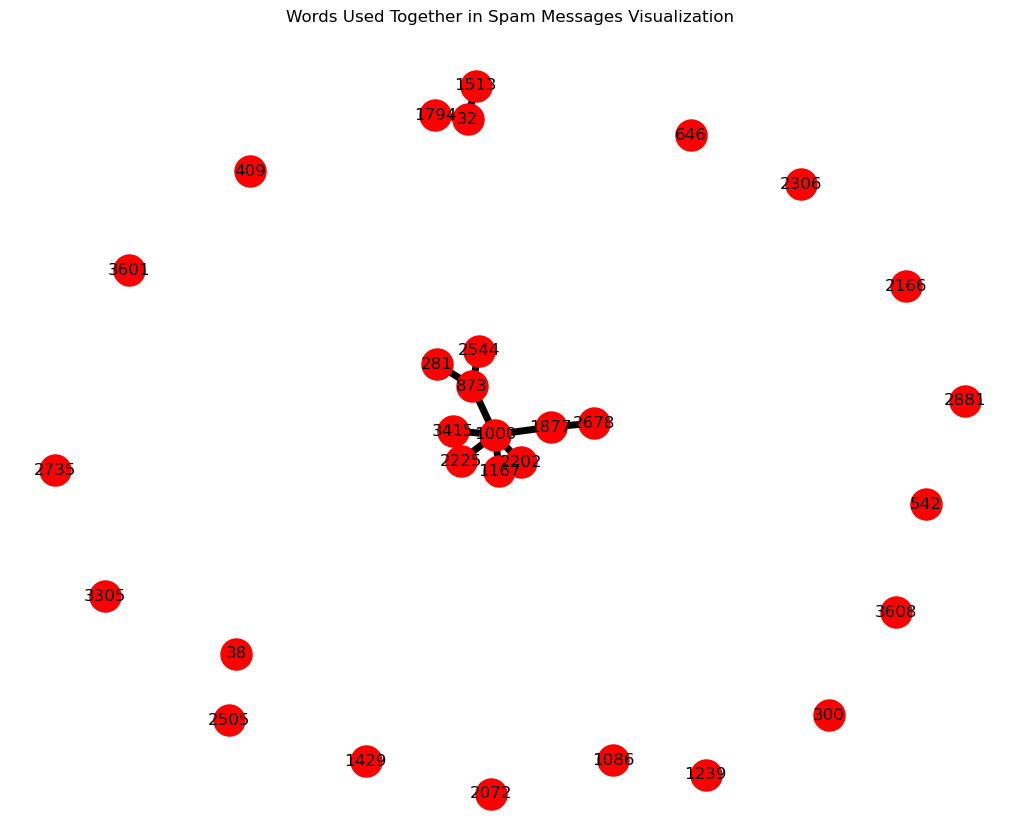

In [249]:
#Defined the number of nodes to display
num_nodes_to_display = 30 #limited the nodes to be displayed to 30

#Randomly selected a subset of nodes
nodes_to_display = random.sample(list(G.nodes), min(num_nodes_to_display, G.number_of_nodes()))

#Created a subgraph for the display
subgraph = G.subgraph(nodes_to_display)

#Specified the layout of the graph
pos = nx.spring_layout(subgraph)  

#Plotted the graph
plt.figure(figsize=(10, 8))
nx.draw(subgraph, pos=pos, node_color='red', with_labels=True, node_size=500, edge_color='black', cmap='coolwarm',
        width=5)  # Adjusted the width parameter for edges so it can be visible
plt.title('Words Used Together in Spam Messages Visualization')
plt.show()

It's essential to note that the graph displayed above does not necessarily imply that nodes without lines connecting them have no edge connections at all. Given the nature of our dataset, it's unlikely that nodes without edges exist. As we mentioned earlier from our code, we limited the nodes displayed for visualization purposes to 30 out of 3680, as visualizing all 3680 nodes would be counterproductive and would not yield any meaningful insights. When we're working with a subset of 30 nodes, the absence of edges for certain nodes simply means that the nodes they are supposed to be linked to are not part of the 30 sampled nodes for visualization. This also highlights the importance of considering the edge information when splitting our data. Simply splitting the nodes into train, validation, and test sets would result in the loss of edge information, which is why we will employ techniques to logically split our graph data.

### Splitting Data

Since we are dealing with graphs, as mentioned earlier, we cannot simply split the nodes because we also have to take into account the edges in-between them, hence, for this task, we will split the data using PyTorch's RandomLinkSplit feature which is a transductive approach of splitting the data. It basically performs edge-level random splits into training, validation and test sets in such  a way that the training split does not include edges found in validation and test splits; and the validation split does not include edges in the test split[4]. This is the approach we took because our task deals with edge-level predictions which means that the labels involved are on an edge-level, hence, it was logical to split only the labels (edges), while all the node features and structure have still been considered for training & validation.


In [27]:
#Split data into train and test sets
transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(data)
print(train_data, val_data, test_data)
print(train_data.edge_index, train_data.edge_label, train_data.edge_label_index)

Data(x=[3680, 100], edge_index=[2, 268010], edge_label=[268010], edge_label_index=[2, 268010]) Data(x=[3680, 100], edge_index=[2, 268010], edge_label=[38286], edge_label_index=[2, 38286]) Data(x=[3680, 100], edge_index=[2, 306296], edge_label=[76574], edge_label_index=[2, 76574])
tensor([[ 194,  200,  546,  ..., 2223, 2890, 2013],
        [1749, 3581, 1279,  ..., 1279,  562, 1594]]) tensor([1., 1., 1.,  ..., 0., 0., 0.]) tensor([[ 194,  200,  546,  ..., 1387,  174, 2875],
        [1749, 3581, 1279,  ..., 2315, 3283,  857]])


### Graph Convolutional Network (GCN) Model Design

The proposed solution is a neural network model designed for link prediction tasks on graph data. It integrates Graph Convolutional Networks (GCN) with additional model performance improvement techniques.For our GNN layers, we will be using the Graph Convolutional Network (GCN) model proposed by Kipf & Welling from the paper Semi-supervised Classification With Graph Convolutional Networks. In the paper, the authors introduced the Graph Convolutional Network (GCN), with the following layer-wise propagation rule:

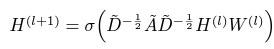


where: 
    
    >A =A+IN represents the adjacency matrix of the undirected graph G with added self-connections. 
    >IN is the identity matrix,
    >Dii is a layer-specific trainable weight matrix. 
    >σ denotes an activation function, such as the ReLU 
    >H(l) ∈ RN×D is the matrix of activations in the lth layer; 
    >H(0) = X.
        
This equation describes how the features of the nodes are aggregated from their neighbors, incorporating the structure of the graph [9]. For the implementation, we will make use of PyTorch's GCNConv package which follows this equation by Kipf & Welling; where Dii is represented as a diagonal degree matrix, the adjacency matrix is represented as edge weights with a node-wise formulation given by the equation as follows:

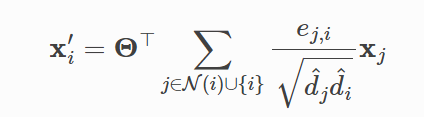

where di is one plus the sum of all eji, which denotes the edge weight from source node j to target node i [10].

### Architecture of GCN Model Design

The design involves 3 GCN layers, each  applied with Batch Normalization to stabilize and accelerate the training process, and Dropout is used on the 1st and 2nd GCN layers to prevent overfitting by randomly setting a fraction of input units to zero during training. Moreover, skip connections are introduced in the architecture to alleviate the vanishing gradient problem and to allow the model to learn identity mappings, which helps in training deeper networks. The 1st Skip connection is implemented by projecting the input features with the help of a linear layer, and consequently adding the projection to the input of the 2nd GCN layer, F(x) + x. The 2nd Skip connection, on the other hand, adds the output of the first GCN layer to the output of the 3rd & final layer, which will be used as inputs to the post-processing layers where edge features will be constructed by concatenating the features of the node pairs for each edge. 

The first and second GCN Layers are applied with ReLU activations to introduce non-linearity and enable the model to learn complex representations. This helps the model capture intricate patterns from the input features. The third GCN layer focuses on combining features and preparing them for edge-level prediction. In this layer, ReLU is not applied immediately because the third GCN layer's output is combined with the output from the first GCN layer (via the second skip connection). This combination process benefits from having raw feature values rather than activated (ReLU-processed) ones. The output edge features from this process will then go through a linear layer, where ReLU activation function shall be applied again. Applying ReLU after concatenation (and before passing through the fully connected layers) ensures that non-linearity is introduced at a stage where it is more meaningful and where the final edge-level predictions are made.Finally, the features are processed by the last linear layer from the post-processing layers for binary classification to perform link prediction where sigmoid, instead of softmax, function is used to get the probability distribution because this is a binary classification task. This design choice allows the model to balance between learning complex node representations and effectively combining these representations for link prediction tasks. The ReLU activations at strategic points ensure that the model remains expressive while avoiding unnecessary transformations that might hinder the flow of gradients or the combination of features. For more details, please refer to the following diagram and codes used.

#### Diagram
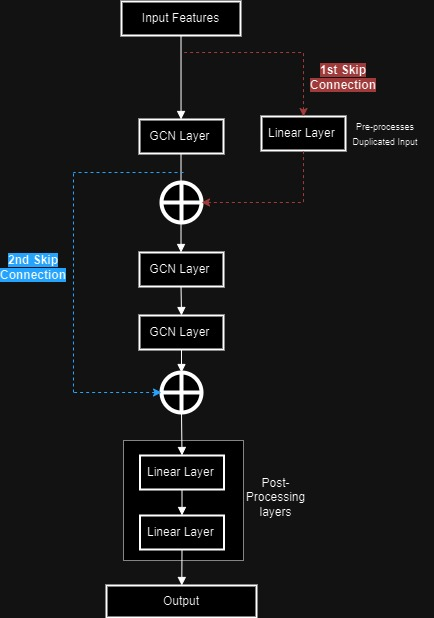

#### Code

In [28]:
class GCNNet(torch.nn.Module): #defined class of the model to be used
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5): #initialies the neural network and parameters
        super(GCNNet, self).__init__() #in_channels is the # of input features per node, hidden_channels is the # of hidden units in the GCN layers
        #out_channels is the # of output features per node which is based on the dimensionality of hidden_channels
        self.conv1 = GCNConv(in_channels, hidden_channels)#1st GCN layer that transforms input features from in_channels to hidden_channels
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels) #Batch normalization layer applied after 1st GCN layer to stabilize and accelerate training
        self.conv2 = GCNConv(hidden_channels, hidden_channels) #2nd GCN layer that keeps the feature size as hidden_channels
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)#Batch normalization layer applied after 2nd GCN layer to stabilize and accelerate training
        self.conv3 = GCNConv(hidden_channels, out_channels) #3rd GCN layer that transforms features from hidden_channels to out_channels
        self.bn3 = torch.nn.BatchNorm1d(out_channels)#Batch normalization layer applied after 3rd GCN layer to stabilize and accelerate training
        self.dropout = torch.nn.Dropout(dropout_rate) #dropout layer
        
        #Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        #Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)#linear layer that takes concatenated edge features (twice the out_channels size because graph is undirected) and transforms them to hidden_channels
        self.fc2 = torch.nn.Linear(hidden_channels, 1)#linear layer that reduces the feature size to 1 for binary classification (link prediction).

    def forward(self, x, edge_index):#Defines the computation performed for the forward pass; how the input tensor x and edge indices edge_index are processed through the network layers.
        
        duplicate2_x = self.proj(x) #Projects the input features x to out_channels using self.proj for the 1st skip connection
        
        #Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index))) #Applies ReLU activation function and batch normalization to the first GCN
        x = self.dropout(x) #applied dropout
        
        duplicate_x = x #stores the output features of the first GCN layer for the second skip connection
        
        ##1st Skip connection
        x = duplicate2_x + x #Adds the projected input features to the current features
        
        x = F.relu(self.bn2(self.conv2(x, edge_index))) #Applies the second GCN layer with batch normalization, ReLU activation, and dropout
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index)) #Applies the third GCN layer with batch normalization
        
        ##2nd Skip connection
        x = duplicate_x + x #Adds the stored output features of the first GCN layer to the current features

        #Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1) #Concatenates the features of the source and target nodes of each edge to form edge features

        #Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features)) #Applies the first linear layer with ReLU activation
        #Applies sigmoid activation to get probabilities for binary classification (link prediction)
        out = torch.sigmoid(self.fc2(edge_features).view(-1)) #Applies the second linear layer and reshapes the output
        return out

#### Model Selection

GCNs have a relatively simpler architecture compared to GraphSAGE and Graph Attention Networks (GAT), making them computationally more efficient. This is because GCNs do not require the computation of attention coefficients for each edge, which can be computationally intensive. Considering our dataset and the task at hand, which involves determining which combinations of words indicate fraud, GCNs are a suitable choice for several reasons. Firstly, GCNs have a straightforward architecture that involves basic matrix multiplications and element-wise operations, leading to faster computations and easier implementation compared to the more complex architectures of GraphSAGE and GAT. Secondly, in our task, all nodes (words) and edges (relationships between words) are treated with equal importance. GCNs aggregate information uniformly from neighboring nodes, which aligns well with our requirement. The flexibility in aggregation functions provided by GraphSAGE is not necessary for our application. Moreover, since our task does not require distinguishing between the importance of different neighbors, the attention mechanism offered by GATs, which assigns different weights to different neighbors, is not needed. GCNs' equal weighting is sufficient for our goal of identifying fraudulent word combinations. Therefore, GCNs are well-suited for our task due to their simplicity, efficiency, and the adequacy of their uniform aggregation approach in the context of our dataset and objective. For these reasons, we then decided to used the GCN model from week 7 workshop as a baseline, which is a simple implementation of GCN, and improved it little by little to arrive at our final best performing model design. 

To validate our hypothesis, we employed the baseline GCN, GraphSage, and GAT models from Workshop Week 7, with minimal modifications to enable them to process the expected inputs and outputs without requiring additional model improvement techniques. Not surprisingly, all three models yielded poor results, as they were used in their raw forms. For more information on the models used, please refer to the Baseline Model Options section of the Appendix. To further support our decision to choose GCN for this task, we will apply the same final design to GraphSage and GAT, and compare their results to verify our choice. This will be discussed in the Other GNN Model Approaches section of this paper.

#### Determining Optimal Number of GCN Layers

Since we are working on a big graph, 3 layers seem to hit the sweet spot as it is unlikely that in the third layer, the node embeddings will have similar values. This has been proven by the experiments performed for the purposes of comparing the model performance of models having different numbers of GCN layers. Models having 2-4 GCN layers have been closely compared, and the best performing model out of the three was the model with 3 GCN layers. The model with 4 GCN layers only slightly performed worse, which hints that having 4 layers is redundant as it adds a lot of unnecessary complexity to the model only to obtain almost the same results as the one with 3 layers. Using 4 GCN layers for our purposes is inefficient as it entails unnecessary risk of undergoing over-smoothing. For more information on the models used for the experiments, please refer to the Models Tested For Optimal Number of GCN Layers from the Appendix.

#### Improving Model Performance

To improve the model's performance, the following steps have been undertaken to make the most out of the GCN layers enabling them to express a lot of information:

1.Batch Normalization
We included batch normalizations  to stabilize training. This basically computes the mean (recenters to zero mean) and variance (rescales variance into unit variance) and consequently normalizes the outputs from the layers.

2.Dropout
We applied dropouts of 0.5 because during our initial runs, we found that the model was performing really well on the training set but not on the validation set. This approach helped curb the problem of overfitting.

3.Linear Layers within GCN layers

We included linear layers to perform the aggregation functions within the GCN layers. By using the torch_geometric GCNConv package, the GCN layers already inherently include linear transformations within the GCN layers that performs aggregation. These transformations are used to perform the message passing and aggregation functions. The GCNConv layers perform both message passing and aggregation that involves aggregating the passed messages and applying linear transformations to the messages.In addition to the linear layers within the GCN layers, we also added linear layers for the post-processing layer which will be further discussed in the following section. 

4.Layers that do not pass messages 

4.1 Pre-processing Layer

Given that we are working on words as nodes, we tried incorporating a pre-processing linear layer since this is a known 
technique when it comes to working on nodes that represent text. However, we found that the model performed worse. This 
is probably because the preprocessing layer transforms the input features into a different space and does not align well 
with the GCN layers, which introduced noise or distortions. The main reason of this misalignment is probably due to the 
fact that we used Glove embeddings to represent the node features. The original embeddings that have not been pre-
processed by a linear layer might have carried crucial information that could have been directly utilized by the GCN 
layers which resulted to a better result. The dataset probably has properties that are already well captured by the 
initial embeddings that have been distorted by further transformation. For these reasons, for our final design, we 
removed the linear layer that pre-processes the input. For more information on the experiment conducted to test this approach, please refer to the Models Tested For Pre-processing Linear Layers from the Appendix. 

We did, however, add a linear layer for the sole purpose of projecting the duplicated input to the dimensions expected by the GCN layers so that it can be added to the output of the first GCN layer to establish a shortcut connection.

4.2 Post-processing Layer
We made use of fully connected linear layers for edge-level prediction as this is a good technique to make GNNs more 
expressive when nodes require transformation. These layers are used to process the concatenated node features of the two 
nodes forming an edge. This is done by concatenating the features of the two nodes for each of the pairs of edges. Then, the 
concatenated features are passed through the fully connected layers to get the edge predictions. The linear layers within 
the GCN layers handle the node feature transformations, while the fully connected post-processing linear layers handle the 
edge feature transformations.

5.Skip Connections
With the introduction of skip connections, we found that the model performed better when shortcut connections to the output of the last GCN layer are included, probably because the effect of over-smoothing were reduced as we do not get the same value of node embeddings despite having a lot of GCN layers.For shortcut or skip connections, one of the common practices is to have a skip connection after every layer as seen in models like ResNet[1]. Adding skip connections after every GCN layer can help in training deeper models. This is more effective in preventing gradient vanishing and allows the model to learn more easily if needed. However, our model is probably not deep enough, because the best model consists of only two shortcut connections. Before we arrived at our final skip connection design, we experimented on all logical permutations of shortcut connections possible. We have observed that most of the models that performed well were the single skip connections that went directly to the output of the last GCN layer or those that have more than one skip connection which had one skip connection that directly connected with the output of the last GCN Layer. Because of this observation, it was logical for the final design to have a shortcut connection to the output of the last GCN Layer. True enough after a series of experiments prior the creation of the final design, two of the best performing designs were models that included the following skip connection combinations: 

A)Input was duplicated by projecting from the original input channels dimension to the output channels dimension by a linear layer, ensuring that the tensors of the duplicated input and the output of the layers have the same shape. This allows for the addition of the duplicated input to the output of the GCN layers. Then, a shortcut connection between this duplicated input and the output of the last GCN layer was established.

B)Instead of duplicating the input, the output of the first layer was duplicated and added to the output of the last GCN layer to form a skip connection. Another iteration of this has been made where the duplicate was also added to the output of the 2nd GCN layer. The result of this iteration was a slightly poorer performance, hinting that the addition of a shortcut connection to the output of the 2nd GCN layer is redundant.

Based on the insights lifted from these two approaches; we tried an approach that combines the strengths of A & B by employing 2 duplicates instead of just one. The approach of creating 2 different duplicates was inspired by the skip connection approach used in the 34-layer residual design from the paper Deep Residual Learning for Image Recognition[1]. Although the paper was primarily intended for image recognition tasks, their novel approach of using shortcut connections by skipping one layer block after every layer block, made us think that in order for this to be possible, corresponding creation of duplicates after every layer block had to be performed. With this said, we made a duplicate of the initial input similar to the approach used in A, and another duplicate which was taken from the output of the first layer similar to approach B. Aside from the fact that these were the approaches from the best performing models from the experiments, these duplicates were selected because of the idea that node embeddings from the earlier layers can better differentiate nodes, hence, the choice to duplicate the initial input and the output of the first gcn layer. After getting the duplicates, the first duplicate was added to the output of the first layer, while the second duplicate was added to the output of the last layer. By doing this approach, we were able to combine the strengths of both approaches, which resulted to the best performing model consisting of a combination of shallow and deep GCNs.

Another approach worth mentioning is an iteration of the final skip connection design where instead of duplicating only the output of the first layer for the second duplicate, the one duplicated was the result of adding the first duplicate to the output of the first layer, which was subsequently added to the output of the last layer. This resulted to a model that performed significantly poorly probably because this approach contributed to the loss of a lot of information from the earlier node embeddings because of the addition of too much information coming from inputs projected by linear layers, which probably introduced a lot of noise, which resulted to the poor performance of the model. Also, for the final skip connection design, we did not try to conduct an iteration that passed skip connections on the output of the 2nd GCN layer anymore because based on other permutations conducted on prior experimentation, models that did this performed relatively worse.

For more information on the different experiments performed to closely compare the performance of employing different skip connection combinations, please see Models Tested For Optimal Skip Connection Combinations from the Appendix.

#### Prediction Head Approach

Since the prediction task at hand is edge-level, we designed the prediction head to expect a pair of node embeddings as its input. In our design, we used the concatenation + Linear approach by basically concatenating the two node embeddings to form edge features and consequently, running the resulting concatenated edge features through a fully connected linear layer that maps the output embeddings from the concatenated edge features to the hidden channels dimension.Lastly, since the edge prediction task specifically aims to perform link prediction, which means that we are only dealing with a binary classification of identifying whether two nodes should have an edge or not; the output is passed through a sigmoid function to get the probability distribution.

We also considered the use of the dot product approach, which is a more straightforward approach to capture interaction between node embeddings. However, due to the complexity of the task at hand, given that we are dealing with embeddings that represent words, the approach of using concatenation and corresponding fully connected linear layers seemed to be the more capable design. The fully connected layers introduce additional non-linear transformations through activation function RELU, which helps the model learn more complex patterns in the data. On the other hand,the dot product approach, being a simple linear operation, lacks the compatibility to work well with fully connected layers that perform non-linear transformations. To prove our hypothesis, we ran 2 models, one model that used dot product without fully connected layers, and another one that used dot product with fully connected layers. Both of them performed poorly and as expected, the one with the application of fully connected layers even performed worse probably because the addition of fully connected layers changed the nature of the representations learned by the model. This could have reduced the effectiveness of this simple interaction approach by introducing unnecessary complexity, thereby, limiting the model's expressive power. For more information on the experiments conducted, please refer to the Dot Product Prediction Head section of the appendix.

### Initializations of Models

In [29]:
#Initialized the model
model = GCNNet(in_channels=100, hidden_channels=256, out_channels=256, dropout_rate=0.5) 

When we increased the number of hidden and output channels, we observed that the model's performance improved up to a certain point. Specifically, we found that setting both hidden_channels and out_channels to 256 yielded the best results. Increasing these parameters further to 512 did not lead to additional performance gains. This is primarily because increasing the number of hidden channels and output channels enhances the model's capacity to learn and represent complex patterns within the data. This is because a larger number of channels allows the model to capture more nuanced features and interactions among nodes. While a higher number of channels can improve the model's ability to learn intricate patterns, it also increases the number of parameters, leading to a more complex model. In our experiments, 256 channels provided a good balance, offering sufficient capacity without leading to overfitting or excessive computational cost. Beyond 256 channels, the performance gains plateaued. This indicates that the additional capacity provided by more channels did not translate into better performance, likely because the model already had enough capacity to capture the necessary patterns with 256 channels. Further increasing the channels led to diminishing returns, where the added complexity did not contribute to improved accuracy or generalization. Models with fewer channels (such as 256) are computationally more efficient, as evidenced by the reduced training time. Please refer to the Model Parameters Testing from the Appendix for more information on the first set of parameters used in the experimentations.

### Optimizer

We used the Adam optimizer for our optimizer as it is one of the most widely used optimizers in deep learning due to its ability to adapt the learning rate for each parameter and its efficient handling of sparse gradients. It includes mechanisms to correct the bias in the estimates of first and second moments, which can be particularly important at the beginning of training [13]. The learning rate, which controls how much to change the model parameters in response to the estimated error each time the model weights are updated was set to 0.01 because this is a relatively common technique and is often used as a starting point before tuning for a specific problem. This means that during each update step, the parameters are adjusted by a magnitude proportional to this learning rate of 0.01.

In [30]:
#Defined optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


### Training & Evaluation

#### Loss Function For Classification

For the loss function, we used PyTorch's binary_cross_entropy_with_logits function, which is appropriate for binary classification tasks. This function combines a sigmoid layer and the binary cross-entropy loss in one function, and it can be recalled that we used sigmoid to compute for our model's probability distribution.This approach directly computes the loss from the logits or the output of the model, which are then similarly transformed into probabilities by the sigmoid function. Basically, in this approach we are measuring the distance between the predicted probabilities and the actual binary labels by getting the log of all predicted values & multiplying them with corresponding actual values, where each value is represented by our edges.

Epoch [1/50], Train Loss: 0.7066, Train Accuracy: 0.6471, Val Loss: 0.7951, Val Accuracy: 0.5000
Epoch [2/50], Train Loss: 0.6092, Train Accuracy: 0.8020, Val Loss: 0.7492, Val Accuracy: 0.5172
Epoch [3/50], Train Loss: 0.5780, Train Accuracy: 0.8269, Val Loss: 0.6299, Val Accuracy: 0.7010
Epoch [4/50], Train Loss: 0.5865, Train Accuracy: 0.7921, Val Loss: 0.7524, Val Accuracy: 0.5586
Epoch [5/50], Train Loss: 0.5778, Train Accuracy: 0.8340, Val Loss: 0.7561, Val Accuracy: 0.5669
Epoch [6/50], Train Loss: 0.5790, Train Accuracy: 0.8347, Val Loss: 0.6815, Val Accuracy: 0.6916
Epoch [7/50], Train Loss: 0.5767, Train Accuracy: 0.8381, Val Loss: 0.6109, Val Accuracy: 0.7880
Epoch [8/50], Train Loss: 0.5748, Train Accuracy: 0.8399, Val Loss: 0.6025, Val Accuracy: 0.7716
Epoch [9/50], Train Loss: 0.5741, Train Accuracy: 0.8372, Val Loss: 0.6090, Val Accuracy: 0.7494
Epoch [10/50], Train Loss: 0.5740, Train Accuracy: 0.8352, Val Loss: 0.6109, Val Accuracy: 0.7542
Epoch [11/50], Train Loss: 0.

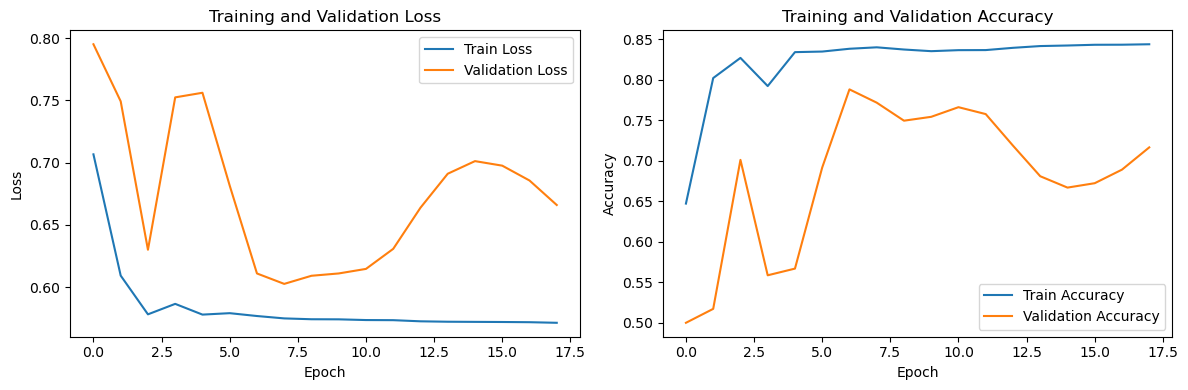

In [31]:
#defined codes for training
import matplotlib.pyplot as plt

def train(model, train_data, val_data, optimizer, num_epochs, patience):
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    
    loss_values = []  # To collect training loss values for plotting
    val_loss_values = []  # To collect validation loss values for plotting
    train_accuracy_values = []  # To collect training accuracy values for plotting
    val_accuracy_values = [] # To collect val accuracy values

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        pred = model(train_data.x, train_data.edge_label_index)
        train_labels = train_data.edge_label

        # Calculate loss
        train_loss = F.binary_cross_entropy_with_logits(pred, train_labels.float())
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy
        threshold = 0.5  
        train_preds = (pred >= threshold).float()
        train_correct = (train_preds == train_labels).sum().item()
        train_accuracy = train_correct / len(train_labels)
        
         # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            val_pred = model(val_data.x, val_data.edge_label_index)
            val_labels = val_data.edge_label

            val_loss = F.binary_cross_entropy_with_logits(val_pred, val_labels.float())

            val_preds = (val_pred >= threshold).float()
            val_correct = (val_preds == val_labels).sum().item()
            val_accuracy = val_correct / len(val_labels)

        # Print training & validation accuracy
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Collect loss and accuracy values
        loss_values.append(train_loss.item())
        val_loss_values.append(val_loss.item())
        train_accuracy_values.append(train_accuracy)
        val_accuracy_values.append(val_accuracy)
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            # Save the best model
            torch.save(best_model_state, 'model_1.pth')
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        # Check for early stopping
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
            
    # Plot training and validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Train Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_values, label='Train Accuracy')
    plt.plot(val_accuracy_values, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model
num_epochs = 50 
patience = 10

train(model, train_data, val_data, optimizer, num_epochs, patience)

In [33]:
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model(test_data.x, test_data.edge_label_index)
        test_labels = test_data.edge_label
        print(test_pred, test_labels)

        # Calculate accuracy
        threshold = 0.5  
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

    return test_accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

tensor([0.9423, 1.0000, 1.0000,  ..., 0.0032, 0.5187, 0.4415]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.8133


Based on the evaluation results, we can see that the model is performing well on the test data with an accuracy of 81.33%. Notably, the graphs indicate overfitting, as the validation loss consistently exceeds the training loss, and the validation accuracy consistently lags behind the training accuracy. For future work, increasing the number of epochs and reducing the patience may help alleviate overfitting because the evaluation graphs suggest that the model is trending towards the training loss and training accuracy curves towards the end. Moreover, it is essential to acknowledge that the model has already shown significant improvement, thanks to the model improvement measures implemented. In comparison to the initial runs made on the model prior to these improvements, the disparity between the training loss and validation loss, as well as the training accuracy and validation accuracy, is significantly reduced. Furthermore, the accuracy on the test data has also experienced a substantial improvement. The results of the initial run can be seen below.

#### Test Worst Result , Also The Initial Run

Epoch [1/50], Train Loss: 0.5940, Train Accuracy: 0.8568, Val Loss: 0.8096, Val Accuracy: 0.5015
Epoch [2/50], Train Loss: 0.5919, Train Accuracy: 0.8553, Val Loss: 0.8109, Val Accuracy: 0.5010
Epoch [3/50], Train Loss: 0.5898, Train Accuracy: 0.8568, Val Loss: 0.8117, Val Accuracy: 0.5006
Epoch [4/50], Train Loss: 0.5868, Train Accuracy: 0.8521, Val Loss: 0.8122, Val Accuracy: 0.5004
Epoch [5/50], Train Loss: 0.5836, Train Accuracy: 0.8546, Val Loss: 0.8124, Val Accuracy: 0.5002
Epoch [6/50], Train Loss: 0.5816, Train Accuracy: 0.8509, Val Loss: 0.8126, Val Accuracy: 0.5002
Epoch [7/50], Train Loss: 0.5796, Train Accuracy: 0.8501, Val Loss: 0.8126, Val Accuracy: 0.5002
Epoch [8/50], Train Loss: 0.5776, Train Accuracy: 0.8499, Val Loss: 0.8127, Val Accuracy: 0.5001
Epoch [9/50], Train Loss: 0.5766, Train Accuracy: 0.8476, Val Loss: 0.8126, Val Accuracy: 0.5003
Epoch [10/50], Train Loss: 0.5759, Train Accuracy: 0.8456, Val Loss: 0.8125, Val Accuracy: 0.5005
Epoch [11/50], Train Loss: 0.

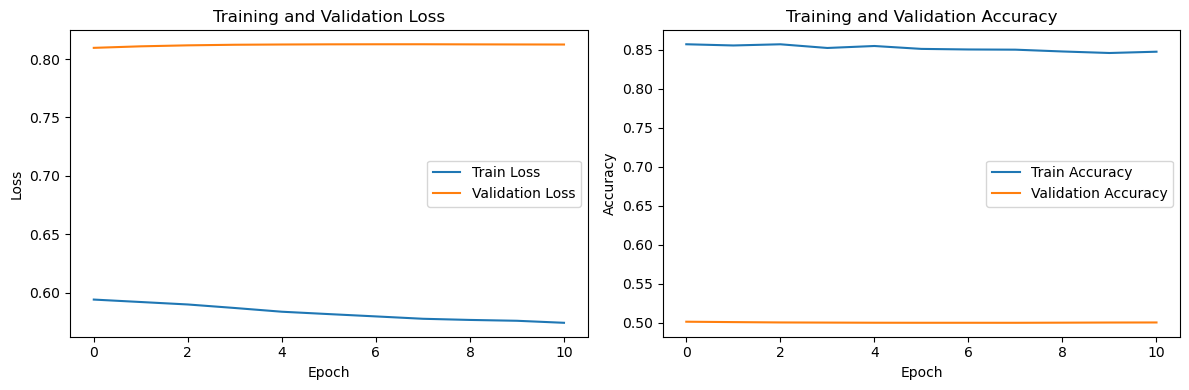

In [37]:
import matplotlib.pyplot as plt

def train(model, train_data, val_data, optimizer, num_epochs, patience):
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    
    loss_values = []  # To collect training loss values for plotting
    val_loss_values = []  # To collect validation loss values for plotting
    train_accuracy_values = []  # To collect training accuracy values for plotting
    val_accuracy_values = [] # To collect val accuracy values

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        pred = model(train_data.x, train_data.edge_label_index)
        train_labels = train_data.edge_label

        # Calculate loss
        train_loss = F.binary_cross_entropy_with_logits(pred, train_labels.float())
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy
        threshold = 0.5  # Adjust the threshold as needed
        train_preds = (pred >= threshold).float()
        train_correct = (train_preds == train_labels).sum().item()
        train_accuracy = train_correct / len(train_labels)
        
         # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            val_pred = model(val_data.x, val_data.edge_label_index)
            val_labels = val_data.edge_label

            val_loss = F.binary_cross_entropy_with_logits(val_pred, val_labels.float())

            val_preds = (val_pred >= threshold).float()
            val_correct = (val_preds == val_labels).sum().item()
            val_accuracy = val_correct / len(val_labels)

        # Print training & validation accuracy
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Collect loss and accuracy values
        loss_values.append(train_loss.item())
        val_loss_values.append(val_loss.item())
        train_accuracy_values.append(train_accuracy)
        val_accuracy_values.append(val_accuracy)
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            # Save the best model
            torch.save(best_model_state, 'model_1.pth')
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        # Check for early stopping
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
            
    

    # Plot training and validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Train Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_values, label='Train Accuracy')
    plt.plot(val_accuracy_values, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model
num_epochs = 50 
patience = 10

train(model, train_data, val_data, optimizer, num_epochs, patience)

In [39]:
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model(test_data.x, test_data.edge_label_index)
        test_labels = test_data.edge_label
        print(test_pred, test_labels)

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

    return test_accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

tensor([0.9875, 0.7268, 1.0000,  ..., 0.9502, 0.9228, 0.8956]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.5044


### Other GNN Model Approaches

In the succeeding parts, we will be applying the same parameters, techniques & methods used by our best performing GCN model design to models that make use of Graph Sage and Graph Attention Network layers. We shall be comparing the results of the two with the performance of our best performing GCN model.

#### Graph Sage

In [50]:
from torch_geometric.nn import SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, dropout_rate=0.5):
        super(SAGE, self).__init__()
        self.conv1 = SAGEConv(input_channels, hidden_channels, aggr='sum') #aggr='max' ...
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr='mean')
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, output_channels, aggr='mean')
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(input_channels, output_channels)
        
        # Fully connected layers for link prediction
        self.fc1 = torch.nn.Linear(output_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))
        
        ##2nd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

#### GAT

In [86]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, dropout_rate=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GATConv(hidden_channels, output_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(input_channels, output_channels)
        
        # Fully connected layers for link prediction
        self.fc1 = torch.nn.Linear(output_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        # Second GAT layer
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        
        # Third GAT layer with attention
        x, attn = self.conv3(x, edge_index, return_attention_weights=True)
        x = F.relu(self.bn3(x))
        
        ##2nd Skip connection
        x = duplicate_x + x 
    
        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out
    

#### Other GNN Model Approaches Evaluation Results

The succeeding parts show the evaluation results of the Graph Sage and GAT models above.

##### Graph Sage

In [54]:
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model(test_data.x, test_data.edge_label_index)
        test_labels = test_data.edge_label
        print(test_pred, test_labels)

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

    return test_accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

tensor([1.0000e+00, 1.0000e+00, 8.3342e-01,  ..., 9.9565e-01, 1.0000e+00,
        9.1451e-19]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.7941


##### GAT

In [90]:
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model(test_data.x, test_data.edge_label_index)
        test_labels = test_data.edge_label
        print(test_pred, test_labels)

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

    return test_accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

tensor([0.0098, 0.0021, 0.0031,  ..., 0.0126, 0.0179, 0.0296]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.5000


Here, we applied all of the parameters and techniques we used on our GCN model to models that made use of Graph Sage and GAT layers. Based on the results, we can confirm that our GCN model design is the best performing model given our chosen dataset, task, context and methods to improve the model. From the results, we can see, especially for GAT that the model performed really poorly. This does not mean that GAT is a terrible model to use rather this just indicates that the current parameters and techniques applied on our GCN design is not compatible with GAT layers. If we used GAT layers for our primary model design, we could have employed other techniques such as experimenting on the number of attention heads to use, and other techniques applicable to GAT that will improve the model performance.

### Ablation Studies:
Understanding the influence of each feature from the model design is crucial, and ablation study is one of the ways we can investigate the direct/indirect effects of these features. For this study, in each section, we will remove or tweak one of the features from our GCN model design and correspondingly check the performance of the new model to investigate the influence of that particular model feature.

In this section, we will be displaying the model and the corresponding test evaluation results. We will not be showing the code for the training run anymore since for this assignment, we have only been using the same training run code and same parameters for all training and evaluation of models. For the actual training run code used, you can refer to the Training & Evaluation section.

#### 1. GCN Layer Reduction.
For the very first part of our ablation study, we will be reducing a GCN layer, and obeserve what happens to model performance.
Prior the conduct of this ablation study, we have already performed preliminary analysis on the optimal number of GCN layers for our final model design as discussed above. Here, we are just removing a GCN layer from our final model design to re-emphasize that 3 GCN layers is the optimal number of layers for our design. For information on other permutations such as a model with 4 GCN layers, kindly refer to Models Tested For Optimal Number of GCN Layers section of the appendix.

##### Ablated Model

In [137]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x 
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        x = self.bn2(self.conv2(x, edge_index))
        
        ##2nd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

##### Test Evaluation Result

In [141]:
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model(test_data.x, test_data.edge_label_index)
        test_labels = test_data.edge_label
        print(test_pred, test_labels)

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

    return test_accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

tensor([1.0000e+00, 1.3572e-04, 7.0952e-02,  ..., 4.1501e-15, 1.0000e+00,
        3.5756e-22]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.8107


Here, we see that the test accuracy is less than our original design's accuracy which is 81.33% This hints that the addition of a 3rd GCN layer slightly improves model performance.

#### 2. Remove batch normalizations from forward pass
In this next ablation study, we will be removing batch normalizations from forward pass.

##### Ablated Model

In [153]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        
        duplicate_x = x 
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        
        ##2nd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

##### Test Evaluation Result

In [157]:
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model(test_data.x, test_data.edge_label_index)
        test_labels = test_data.edge_label
        print(test_pred, test_labels)

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

    return test_accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

tensor([1.3550e-31, 2.1496e-21, 3.7495e-18,  ..., 1.2683e-15, 2.9590e-36,
        3.3780e-15]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.5000


Based on the results, we can see that batch normalizations significantly improved the performance of our model design, hence, confirming that the strategic placing of batch normalization layers from our design significantly improves model performance.

#### 3. Remove dropout
In this part, we will be removing the dropout layers

##### Ablated Model

In [158]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        
        duplicate_x = x 
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))

        x = self.bn3(self.conv3(x, edge_index))
        
        ##2nd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

##### Test Evaluation Results

In [162]:
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model(test_data.x, test_data.edge_label_index)
        test_labels = test_data.edge_label
        print(test_pred, test_labels)

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

    return test_accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

tensor([1.0000e+00, 9.9658e-01, 5.1531e-01,  ..., 9.5402e-04, 7.1088e-01,
        7.7193e-06]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.8103


Here, we see that the test accuracy is less than our original design's accuracy which is 81.33% This hints that the addition of dropout layers slightly improve model performance.

#### 4. Remove All Skip Connections
In this section, we will be removing all skip connections. Recall that it was discussed earlier that prior the establishment of the final design of our GCN model, we conducted several experiments to determine the best combinations of skip connections. To see all the permutations made, please refer to the Appendix.

##### Ablated Model

In [171]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

##### Test Evaluation Results

In [175]:
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        test_pred = model(test_data.x, test_data.edge_label_index)
        test_labels = test_data.edge_label
        print(test_pred, test_labels)

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

    return test_accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

tensor([0.9999, 0.8758, 0.9941,  ..., 0.6768, 0.0393, 0.0050]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.6751


Based on the test accuracy results, we can confirm that our strategic placing of skip connections contributed to the signficant improvement of our model performance as our model's performance on test data is at 81.33%

### Comparison of GCN Model Design Against Existing Link Prediction Model
For this section, we will be comparing our GCN Model Design with a well-established link prediction model to ensure a fair comparison with a model that performs the same task of predicting the existence of edges between nodes. The specific model we will be comparing our model with is Tomonori Masui's Link Prediction model, which is based on his paper on Graph Neural Networks with PyG on Node Classification, Link Prediction, and Anomaly Detection. We chose this model because it is grounded in a novel paper, specifically the Variational Graph Auto-Encoders paper by Thomas N. Kipf & Max Welling [11, 12]. Moreover, Masui's model has achieved a high AUC score of 92.5%, indicating its effectiveness in predicting edge connections between nodes. Additionally, the model employs negative sampling during training, which is a strategy that our model design does not currently utilize. Aside from this, the model also uses the dot product method instead of the concatenation+linear method that my model made use of, so it will be really interesting to compare the two.

To keep the integrity of the model, we tried our best not to tweak or change anything in the design. The only thing we changed is how accuracy and loss values are measured. Instead of using AUC, we employed similar evaluation methods to those used to assess the performance of our GCN model, allowing for a direct comparison of the results.

#### Tomonori Masui's Link Prediction model

In [128]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

def train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=50, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # Sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse'
        )

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        pred = model.decode(z, edge_label_index).view(-1)

        # Calculate training loss and accuracy
        train_loss = F.binary_cross_entropy_with_logits(pred, edge_label.float())
        train_loss.backward()
        optimizer.step()

        threshold = 0.5  # Adjust the threshold as needed
        train_preds = (pred >= threshold).float()
        train_correct = (train_preds == edge_label).sum().item()
        train_accuracy = train_correct / len(edge_label)

        # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            val_pred = model.decode(z, val_data.edge_label_index).view(-1)
            val_labels = val_data.edge_label

            val_loss = F.binary_cross_entropy_with_logits(val_pred, val_labels.float())

            val_preds = (val_pred >= threshold).float()
            val_correct = (val_preds == val_labels).sum().item()
            val_accuracy = val_correct / len(val_labels)

        print(f'Epoch [{epoch}/{n_epochs}], Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            # Save the best model
            torch.save(best_model_state, 'model_1.pth')
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        # Check for early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    return model

In [129]:
model = Net(100, 256, 256)#we used the same parameters as well
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

Epoch [1/50], Train Loss: 0.8454, Train Accuracy: 0.6619, Val Loss: 0.8815, Val Accuracy: 0.5120
Epoch [2/50], Train Loss: 1.3024, Train Accuracy: 0.2682, Val Loss: 0.5798, Val Accuracy: 0.8057
Epoch [3/50], Train Loss: 0.6956, Train Accuracy: 0.8786, Val Loss: 0.6432, Val Accuracy: 0.5827
Epoch [4/50], Train Loss: 0.6834, Train Accuracy: 0.7909, Val Loss: 0.6478, Val Accuracy: 0.5756
Epoch [5/50], Train Loss: 0.6875, Train Accuracy: 0.7869, Val Loss: 0.6417, Val Accuracy: 0.6084
Epoch [6/50], Train Loss: 0.6922, Train Accuracy: 0.8014, Val Loss: 0.6357, Val Accuracy: 0.6414
Epoch [7/50], Train Loss: 0.6966, Train Accuracy: 0.8155, Val Loss: 0.6299, Val Accuracy: 0.6705
Epoch [8/50], Train Loss: 0.6999, Train Accuracy: 0.8268, Val Loss: 0.6241, Val Accuracy: 0.6927
Epoch [9/50], Train Loss: 0.7015, Train Accuracy: 0.8357, Val Loss: 0.6187, Val Accuracy: 0.7084
Epoch [10/50], Train Loss: 0.7005, Train Accuracy: 0.8418, Val Loss: 0.6142, Val Accuracy: 0.7163
Epoch [11/50], Train Loss: 0.

In [135]:
@torch.no_grad()
def test(model, test_data, model_path='model_1.pth'):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # Forward pass
        z = model.encode(test_data.x, test_data.edge_index)
        test_pred = model.decode(z, test_data.edge_label_index).view(-1)
        test_labels = test_data.edge_label

        # Calculate loss
        test_loss = F.binary_cross_entropy_with_logits(test_pred, test_labels.float())

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        test_preds = (test_pred >= threshold).float()
        test_correct = (test_preds == test_labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(test_data.edge_label)
        test_accuracy = test_correct / test_edge_count

        print(f'Test Accuracy: {test_accuracy:.4f}')

    return test_loss, test_accuracy

# Test the model on the test data
test_loss, test_accuracy = test(model, test_data)

Test Accuracy: 0.7998


Based on the evaluation results, we can see that Tomonori Masui's Link Prediction model performs really well. It is almost as good as our own GCN model with a test accuracy of 81.33% Following this comparison, we can confidently conclude that our own GCN model design holds its own against existing models employed for link prediction, demonstrating a level of performance that is comparable to, if not surpassing, established benchmarks. Furthermore, we hope that our design and the insights gleaned from it will serve as a foundation for future innovations in the realm of fraud detection, ultimately contributing to the development of more effective and efficient methods for identifying fraudulent activities.

# References

1. Deep Residual Learning for Image Recognition by Kaiming He, Xiangyu Zhang, Shaoqing Ren & Jian Sun 
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1512.03385

2. GloVe: Global Vectors for Word Representation by Jeffrey Pennington, Richard Socher & Christopher D. Manning of Stanford University

3. Torchtext vocab Pretrained Word Embeddings by GloVe: https://pytorch.org/text/stable/vocab.html#glove

4. RandomLinkSplit by PyTorch: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RandomLinkSplit.html

5. Workshop Week 7

6. Workshop Week 8

7. Huggingface transformers pipeline example for semantic analysis: https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis?library=transformers

8. SMS Spam Collection from UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

9. SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS by Thomas N. Kipf & Max Welling: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1609.02907

10. conv.GCNConv by PyTorch: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html

11. Tomonori Masui's Link Prediction model from his paper on Graph Neural Networks with PyG on Node Classification, Link Prediction, and Anomaly Detection: https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275 

12. Thomas N. Kipf & Max Welling's Variational Graph Auto-Encoders: https://arxiv.org/abs/1611.07308 

13. Diederik P. Kingma & Jimmy Lei Ba's ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION paper: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1412.6980

# APPENDIX

## Model Parameters Testing

The one below was the initial set of parameters used for the first iteration of the initial model design. This set of parameters performed the worst with only an accuracy of 50.44. 

In [120]:
# Initialize the model
model = GCNNet(in_channels=100, hidden_channels=64, out_channels=32, dropout_rate=0.5) #set out_channels to 32 because we're doing link prediction and this should be set based on dimensionality

## Models Tested For Optimal Number of GCN Layers

### 2 layers

In [172]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x, edge_index))

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### 3 layers

This performed the best out of the 3, and was used for the final design of this paper.

In [167]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### 4 layers

This performed slightly worse than 3 layers. Therefore, 3 layers is better as 4 layers may be redundant as it may actually contribute to the Over-smoothing problem where nodes exponentially increase as layers are increased; and the node embeddings eventually converge to the same value instead of allowing the node embeddings to be differentiated.

In [178]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.bn4 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = self.dropout(x)
        x = self.bn4(self.conv4(x, edge_index))

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

## Models Tested For Pre-processing Linear Layers

Based on the best model that resulted from Models Tested For Optimal Number of GCN Layers, which is the model that has 3 GCN layers, the model was added with a pre-processing linear layer to see if the model will improve.

In [183]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        
        # Preprocessing linear layer
        self.preprocess = torch.nn.Linear(in_channels, hidden_channels)
        
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        # Preprocessing
        x = F.relu(self.preprocess(x))
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

## Models Tested For Optimal Skip Connection Combinations

Based on the best model that resulted from Models Tested For Optimal Number of GCN Layers, which is the model that has 3 GCN layers, different permutations of models containing logical skip connection combinations have been closely compared in terms of model performance. 

### 2 Skip Connections with 2 Duplicates (Duplicate Projected Initial Input & Duplicate of First Layer Output)
This performed the best out of all the skip connection combinations.

#### Accuracy: 0.8133

In [ ]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))
        
        ##2nd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### One Skip Connection (Duplicate of First Layer Output Connection to the Output of the Last GCN Layer)

#### Accuracy score: 0.8112 - model perfomed really well.

In [243]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))
        
        ## Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### 2 Skip Connections: Duplicates from Outputs of 1st & 2nd layers

In [44]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x 
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        
        duplicate2_x = x
        
        ##1st Skip connection
        x = duplicate_x + x
        
        x = self.bn3(self.conv3(x, edge_index))
        
        ##2nd Skip connection
        x = duplicate2_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### 2 Skip Connections (2nd Skip was a duplicate of the result of adding the first duplicate to the output of the first layer)

This performed the worst out of all the skip connection permutations with an accuracy of only 0.56.

In [39]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        duplicate_x = x 
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))
        
        ##2nd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### One Skip Connection: Duplicate Projected Initial Input Connection to Output of the Last GCN Layer

This model performed well.

In [200]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate_x = self.proj(x)  # Projecting x to the same dimension as out_channels
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))
        
        ## Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### One Skip Connection: Duplicate Projected Initial Input Connection to Output of the Second GCN Layer

In [206]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate_x = self.proj(x)  # Projecting x to the same dimension as out_channels
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        
        ## Skip connection
        x = duplicate_x + x
        
        x = self.bn3(self.conv3(x, edge_index))

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### One Skip Connection: Duplicate Projected Initial Input Connection to Output of the First GCN Layer

In [211]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate_x = self.proj(x)  # Projecting x to the same dimension as out_channels
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        ## Skip connection
        x = duplicate_x + x
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### 3 Skips Connection: All Paths Possible From Duplicating Projected Initial Input

The result of this model is as good as the model with One Skip Connection: Duplicate Projected Initial Input Connection to Output of the Last GCN Layer; which hints that having all skip connections possible coming from the same initial input is redundant.

In [216]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate_x = self.proj(x)  # Projecting x to the same dimension as out_channels
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        ## 1st Skip connection
        x = duplicate_x + x
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        
        ## 2nd Skip connection
        x = duplicate_x + x
        
        x = self.bn3(self.conv3(x, edge_index))
        
        ## 3rd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### 2 Skip Connections: Duplicate Projected Initial Input Connections to Output of the 2nd & Last GCN Layer

In [221]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate_x = self.proj(x)  # Projecting x to the same dimension as out_channels
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        
        ## 2nd Skip connection
        x = duplicate_x + x
        
        x = self.bn3(self.conv3(x, edge_index))
        
        ## 3rd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### One Skip Connection: Duplicate Output of First Layer Connection to Output of the Second GCN Layer

In [233]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        
        ## Skip connection
        x = duplicate_x + x
        
        x = self.bn3(self.conv3(x, edge_index))
        
        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### 2 Skip Connections: Duplicate Output of First Layer Connection to Output of the 2nd & Last GCN Layer

#### Accuracy: 80.72

This model performed really well. However, it was still outperformed by the model with the same skip connection design but without the skip connection the the output of the 2nd GCN layer.

In [238]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        
        ## 1st Skip connection
        x = duplicate_x + x
        
        x = self.bn3(self.conv3(x, edge_index))
        
        ## 2nd Skip connection
        x = duplicate_x + x
        
        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

### One Skip Connection: Duplicate Output of Second GCN Layer Connection to Output of Last GCN Layer
Since we have tested everything already except for duplicating the output of the second layer, we then tested this as well for the sake of comparison. As expected, it did not provide the best performing model probably because using the duplicate of the output of the 2nd GCN layer does not capture the information from the earlier node embedding inputs that well.

In [248]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        x = self.bn3(self.conv3(x, edge_index))
        
        ##Skip connection
        x = duplicate_x + x
        
        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

## Dot Product Prediction Head

### Dot Product with Fully Connected Layers

In [50]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels)

        # Fully connected layers after dot product
        self.fc1 = torch.nn.Linear(1, hidden_channels)  # Assuming the dot product results in a single value
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))
        
        ##2nd Skip connection
        x = duplicate_x + x

        # Edge-level prediction
        dot_product = (x[edge_index[0]] * x[edge_index[1]]).sum(dim=-1, keepdim=True)  # Dot product

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(dot_product))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out


### Dot Product without Fully Connected Layers

In [45]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(GCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        # Projection layer for skip connection
        self.proj = torch.nn.Linear(in_channels, out_channels) # linear layer to project duplicate_x to be the same dimension as x

    def forward(self, x, edge_index):
        
        duplicate2_x = self.proj(x)
        
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        
        duplicate_x = x #self.proj(x)  # Projecting x to the same dimension as out_channels
        
        ##1st Skip connection
        x = duplicate2_x + x
        
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))
        
        ##2nd Skip connection
        x = duplicate_x + x

        # Edge-level prediction using dot product
        x_i = x[edge_index[0]]
        x_j = x[edge_index[1]]
        edge_features = (x_i * x_j).sum(dim=-1)  # Dot product of node features

        # Pass through a sigmoid to get probabilities
        out = torch.sigmoid(edge_features)
        return out


### Baseline Model Options

#### Baseline GCN

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, output_channels)
        
        # Fully connected layers for link prediction
        self.fc1 = torch.nn.Linear(output_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        
        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

#### Baseline Graph Sage

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(SAGE, self).__init__()
        self.conv1 = SAGEConv(input_channels, hidden_channels, aggr='sum') #aggr='max' ...
        self.conv2 = SAGEConv(hidden_channels, output_channels, aggr='mean')
        
        # Fully connected layers for link prediction
        self.fc1 = torch.nn.Linear(output_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        # First SAGE layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # Second SAGE layer
        x = self.conv2(x, edge_index)

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

#### Baseline GAT

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, output_channels)
        
        # Fully connected layers for link prediction
        self.fc1 = torch.nn.Linear(output_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        # First GAT layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # Second GAT layer
        x, attn = self.conv2(x, edge_index, return_attention_weights=True)
        
        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out